# Lab ML for DS SS23
## Project 2
#### Jan Jascha Jestel (5547158)
#### Mustafa Suman (5564676)
#### Gabriele Inciuraite (5208806)

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from scipy.io import loadmat
from scipy.spatial.distance import pdist
from scipy.stats import norm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from itertools import combinations_with_replacement, combinations


# 1. Importing the QM7 Dataset

In [2]:
# The QM7 dataset consists of 7165 organic molecules, each of which is composed of up to 23 atoms.
qm7 = loadmat("./qm7.mat")
print(qm7.keys())

dict_keys(['__header__', '__version__', '__globals__', 'X', 'R', 'Z', 'T', 'P'])


In [3]:
# R (7165×23×3) contains for each molecule and atom a triplet representing the 3d coordinates
display(qm7['R'].shape)
display(qm7['R'][0])

(7165, 23, 3)

array([[ 1.886438  , -0.00464873, -0.00823921],
       [ 3.9499245 , -0.00459203,  0.00782347],
       [ 1.1976895 ,  1.9404842 ,  0.00782347],
       [ 1.1849339 , -0.99726516,  1.6593875 ],
       [ 1.2119948 , -0.9589793 , -1.710958  ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.   

In [4]:
# Z (7165×23) contains for each molecule and atom of the molecule the corresponding atomic number

# 0 == no atom at this index
# 1 == hydrogen (H)
# 6 == carbon (C)
# 7 == nitrogen (N) 
# 8 == oxygen (O)
# 16 == sulfur (S)
display(qm7['Z'].shape)
display(qm7['Z'][0])

(7165, 23)

array([6., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.], dtype=float32)

(1, 7165)

-417.96

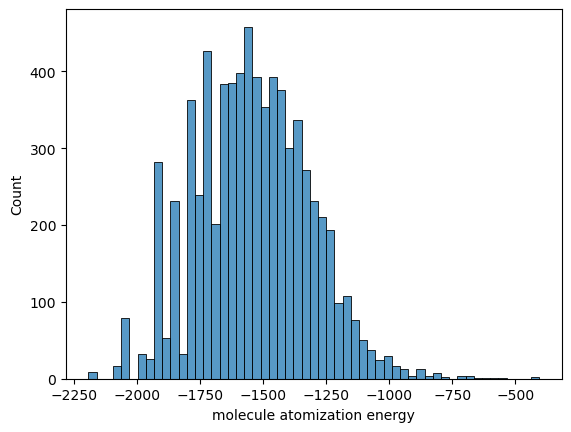

In [5]:
# T (1 x 7165) contains for each molecule the atomization energy (computed via quantum-chemical simulation)
display(qm7['T'].shape)
display(qm7['T'][0, 0])

g = sns.histplot(qm7['T'][0])
g.set_xlabel('molecule atomization energy')
plt.show()

# 1.1 Visualizing Molecules

### "quick and dirty approach"

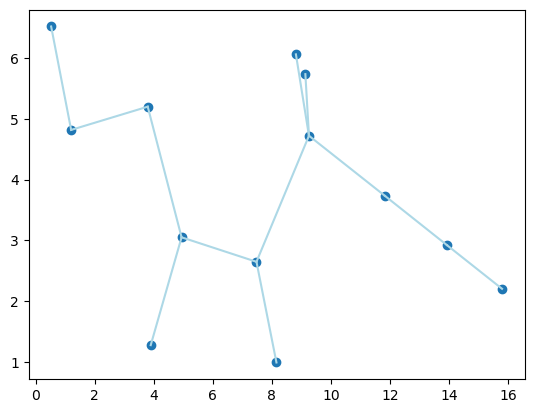

In [6]:
nr = 6400

mol = qm7["R"][nr]
sym = qm7["Z"][nr]

sym = sym[sym > 0]
mol = mol[: len(sym)]

plt.scatter(x=mol[:, 0], y=mol[:, 1])


# generate bonds
thresh = 3

mask = np.argwhere(pdist(mol, metric="euclidean") < thresh)[:, 0]
bonds = np.vstack(np.triu_indices(len(mol), 1)).T[mask]

for i in range(len(bonds)):
    plt.plot(mol[bonds[i]][:, 0], mol[bonds[i]][:, 1], color="lightblue")


### Atomic Simulation Environment

In [7]:
from ase import Atoms
import nglview
import ase.visualize

system = Atoms(positions=mol, symbols=sym)
# ase.visualize.view(system, viewer="x3d")

view = nglview.show_ase(system)
view.add_ball_and_stick() # HOW TO SPECIFY BONDS?????
view

# Other viz approaches
# https://www.kaggle.com/code/mykolazotko/3d-visualization-of-molecules-with-plotly
# nglview

NGLWidget()

# 2. Data Representation, ML Model and Explanations

# 2.1 Data Representation

In [8]:
# one hot encoding of [HCNOS]

# 1 == hydrogen (H)
# 6 == carbon (C)
# 7 == nitrogen (N)
# 8 == oxygen (O)
# 16 == sulfur (S)

z = qm7["Z"].astype(np.int8)

z[z == 1] = 1
z[z == 6] = 2
z[z == 7] = 3
z[z == 8] = 4
z[z == 16] = 5

Z_hot = np.eye(6)[z]
Z_hot = Z_hot[:, :, 1:]  # drop 0 dimension

# sum of to create the representation
x = np.sum(Z_hot, axis=1).astype(int)

print("Shape:", x.shape)
print("Resulting representations:")
print(x)


Shape: (7165, 5)
Resulting representations:
[[ 4  1  0  0  0]
 [ 6  2  0  0  0]
 [ 4  2  0  0  0]
 ...
 [ 9  6  1  0  0]
 [10  7  0  0  0]
 [12  7  0  0  0]]


# 2.2 Ridge Regression Model

In [9]:
# split train / test 
X_train, X_test, y_train, y_test = train_test_split(x, qm7['T'][0], test_size=0.3, random_state=42)

# center data and target
X_train_mean = np.mean(X_train, axis=0)
y_train_mean = np.mean(y_train)

X_train = X_train - X_train_mean
X_test = X_test - X_train_mean

y_train = y_train - y_train_mean
y_test = y_test - y_train_mean

In [10]:
# Grid search to tune alpha using 10-fold cross validation

ridge = Ridge()
alpha_values = np.logspace(np.log10(1e-4), np.log10(100), num=100)
grid = dict(alpha=alpha_values)
search = GridSearchCV(
    ridge,
    grid,
    scoring=("neg_mean_absolute_error"), # 'r2', 'neg_mean_squared_error'
    cv=10,
    n_jobs=-1,
    refit="neg_mean_absolute_error",
    return_train_score=True,
)  

results = search.fit(X_train, y_train)


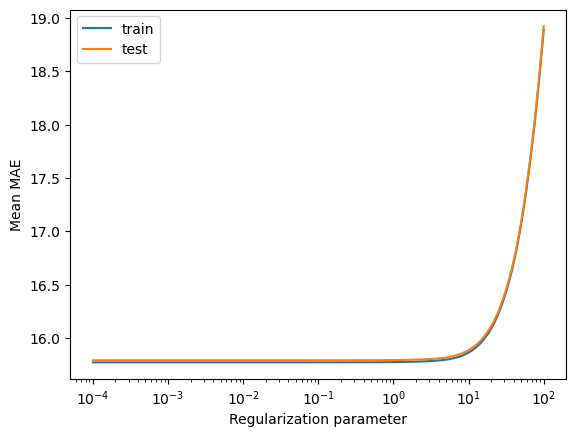

In [11]:
ax = sns.lineplot(x=alpha_values, y = -results.cv_results_['mean_train_score'], label='train')
ax = sns.lineplot(x=alpha_values, y = -results.cv_results_['mean_test_score'], label='test')
ax.set_xscale('log')
ax.set_xlabel('Regularization parameter')
ax.set_ylabel('Mean MAE')
plt.legend(loc='upper left')
plt.show()

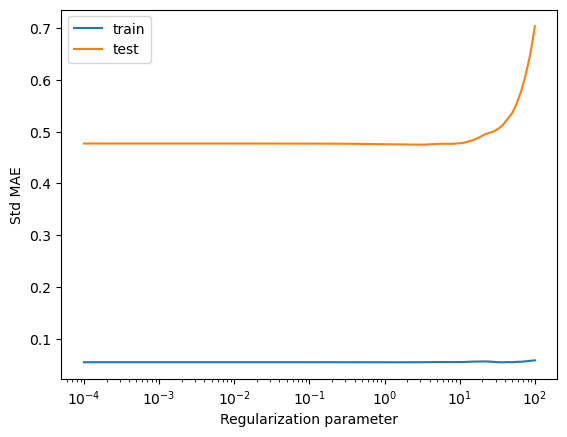

In [12]:
ax = sns.lineplot(x=alpha_values, y = results.cv_results_['std_train_score'], label='train')
ax = sns.lineplot(x=alpha_values, y = results.cv_results_['std_test_score'], label='test')
ax.set_xscale('log')
ax.set_xlabel('Regularization parameter')
ax.set_ylabel('Std MAE')
plt.legend(loc='upper left')
plt.show()

Best parameter: {'alpha': 0.0001}
R2: 0.992
MAE: 15.461
MSE: 403.582


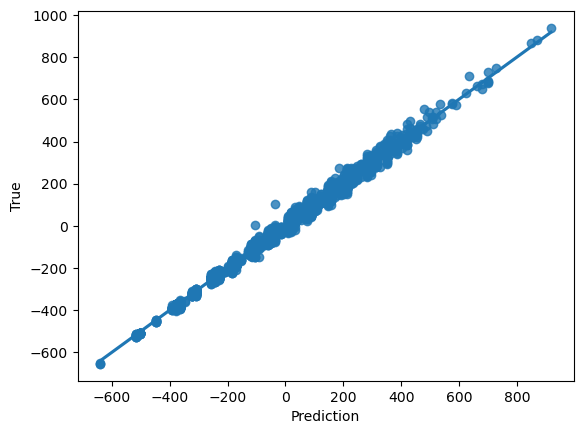

In [13]:
y_pred = search.best_estimator_.predict(X_test)
print("Best parameter:", results.best_params_)
print(f"R2: {r2_score(y_test, y_pred):.3f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.3f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.3f}")
g = sns.regplot(x=y_pred, y=y_test)
g.set_xlabel("Prediction")
g.set_ylabel("True")
plt.show()


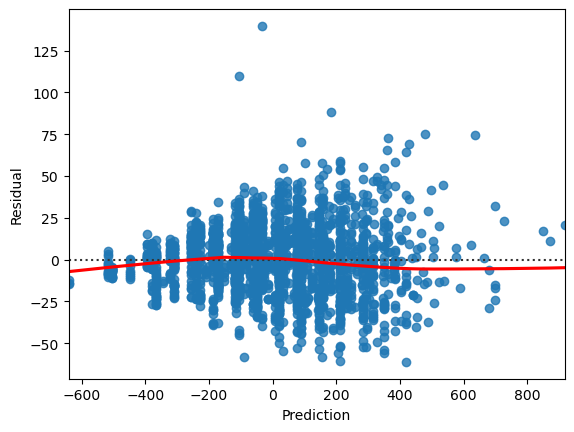

In [14]:
g = sns.residplot(x=y_pred, y=y_test, lowess=True, line_kws=dict(color="r"))
g.set_xlabel("Prediction")
g.set_ylabel("Residual")
plt.show()


# 2.3 Deeper Insights with Explanations 
# 3. Experiments 
# 3.1 Simple atom-based Representation

In [15]:
print(f"MAE: {mean_absolute_error(y_test, search.best_estimator_.predict(X_test)):.3f}")
print("Ri:", search.best_estimator_.coef_)


MAE: 15.461
Ri: [ -68.68727583 -157.410442   -102.41624528 -101.15629173  -80.54594189]


<AxesSubplot: >

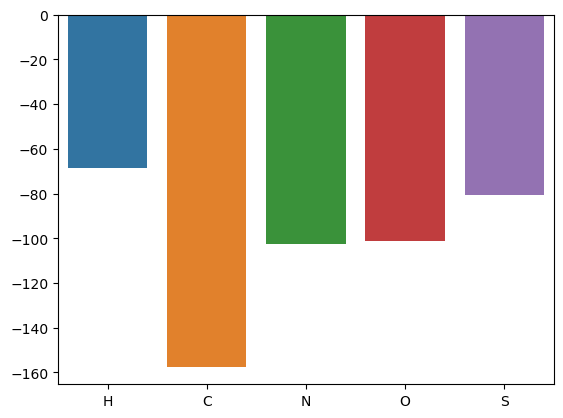

In [16]:
sns.barplot(x=["H", "C", "N", "O", "S"], y=search.best_estimator_.coef_)
# TODO Compare the produced insights with existing chemical knowledge or the literature.

# 3.2 Models with Pairs of Atoms

In [17]:
theta_1 = 2
theta_m = 4
m = 100

N_COMB = 824783

intervals = np.linspace(theta_1, theta_m, m)
interval_size = (theta_m - theta_1) / (m - 1)
interval_centeres = intervals[:-2] + interval_size

In [18]:
# create dictionary to translate atom combinations to number between 0 and 14
d = {c: i for i, c in enumerate(combinations_with_replacement([1, 2, 3, 4, 5], r=2))}

inv = {}
for c in d:
    inv[c[1], c[0]] = d[c]

d = d | inv
del inv


In [19]:
# generate arrays with the distances and the types of all pairs
pair_dist = np.zeros(N_COMB) # all distances
pair_type = np.zeros(N_COMB).astype(int) # all types
mol_split = np.zeros(7165 + 1).astype(int) # indices where to split the array to get the molecules
pair_idx = 0

for i in range(len(z)):
    sym = z[i]
    sym = sym[sym != 0]
    mol = qm7["R"][i][: len(sym)]

    dist = pdist(mol, metric="euclidean")
    comb = [*combinations(sym, r=2)]
    n_combs = len(comb)
    
    pair_dist[pair_idx : pair_idx + n_combs] = dist
    pair_type[pair_idx : pair_idx + n_combs] = [d[x] for x in comb]

    mol_split[i] = pair_idx
    pair_idx += n_combs

mol_split[-1] = N_COMB

In [20]:
# generate phi_A(Ei)
phi_A_soft = np.zeros((len(pair_dist), m))
for j, mu in enumerate(interval_centeres):
    phi_A_soft[:, j] = norm.pdf(pair_dist, loc=mu, scale=0.5)

# hard encoding
# indices = np.floor((pair_dist - theta_1) / interval_size).astype(int)
# phi_A_E_hard = np.zeros((len(indices), m), dtype=int)
# phi_A_E_hard[indices < m] = np.eye(m)[indices[indices < m]]

# generate phi_B(Ei)
phi_B = np.eye(15)[pair_type].astype(int)

# generate phi(Ei)
phi_AB = phi_A_soft[:, :, None] * phi_B[:, None, :]
phi_AB = phi_AB.reshape(N_COMB, -1)

# aggregate for molecule representation
reps = np.zeros((len(z), m * 15))
for i in range(len(mol_split)):
    reps[i - 1, :] = np.sum(phi_AB[mol_split[i - 1] : mol_split[i]], axis=0)


In [21]:
# split train / test 
X_train, X_test, y_train, y_test = train_test_split(reps, qm7['T'][0], test_size=0.3, random_state=42)

# center data and target
X_train_mean = np.mean(X_train, axis=0)
y_train_mean = np.mean(y_train)

X_train = X_train - X_train_mean
X_test = X_test - X_train_mean

y_train = y_train - y_train_mean
y_test = y_test - y_train_mean

In [22]:
model = Ridge(alpha = 1e-6)
model.fit(X_train, y_train)
mean_absolute_error(y_test, model.predict(X_test))

6.7786040744964815

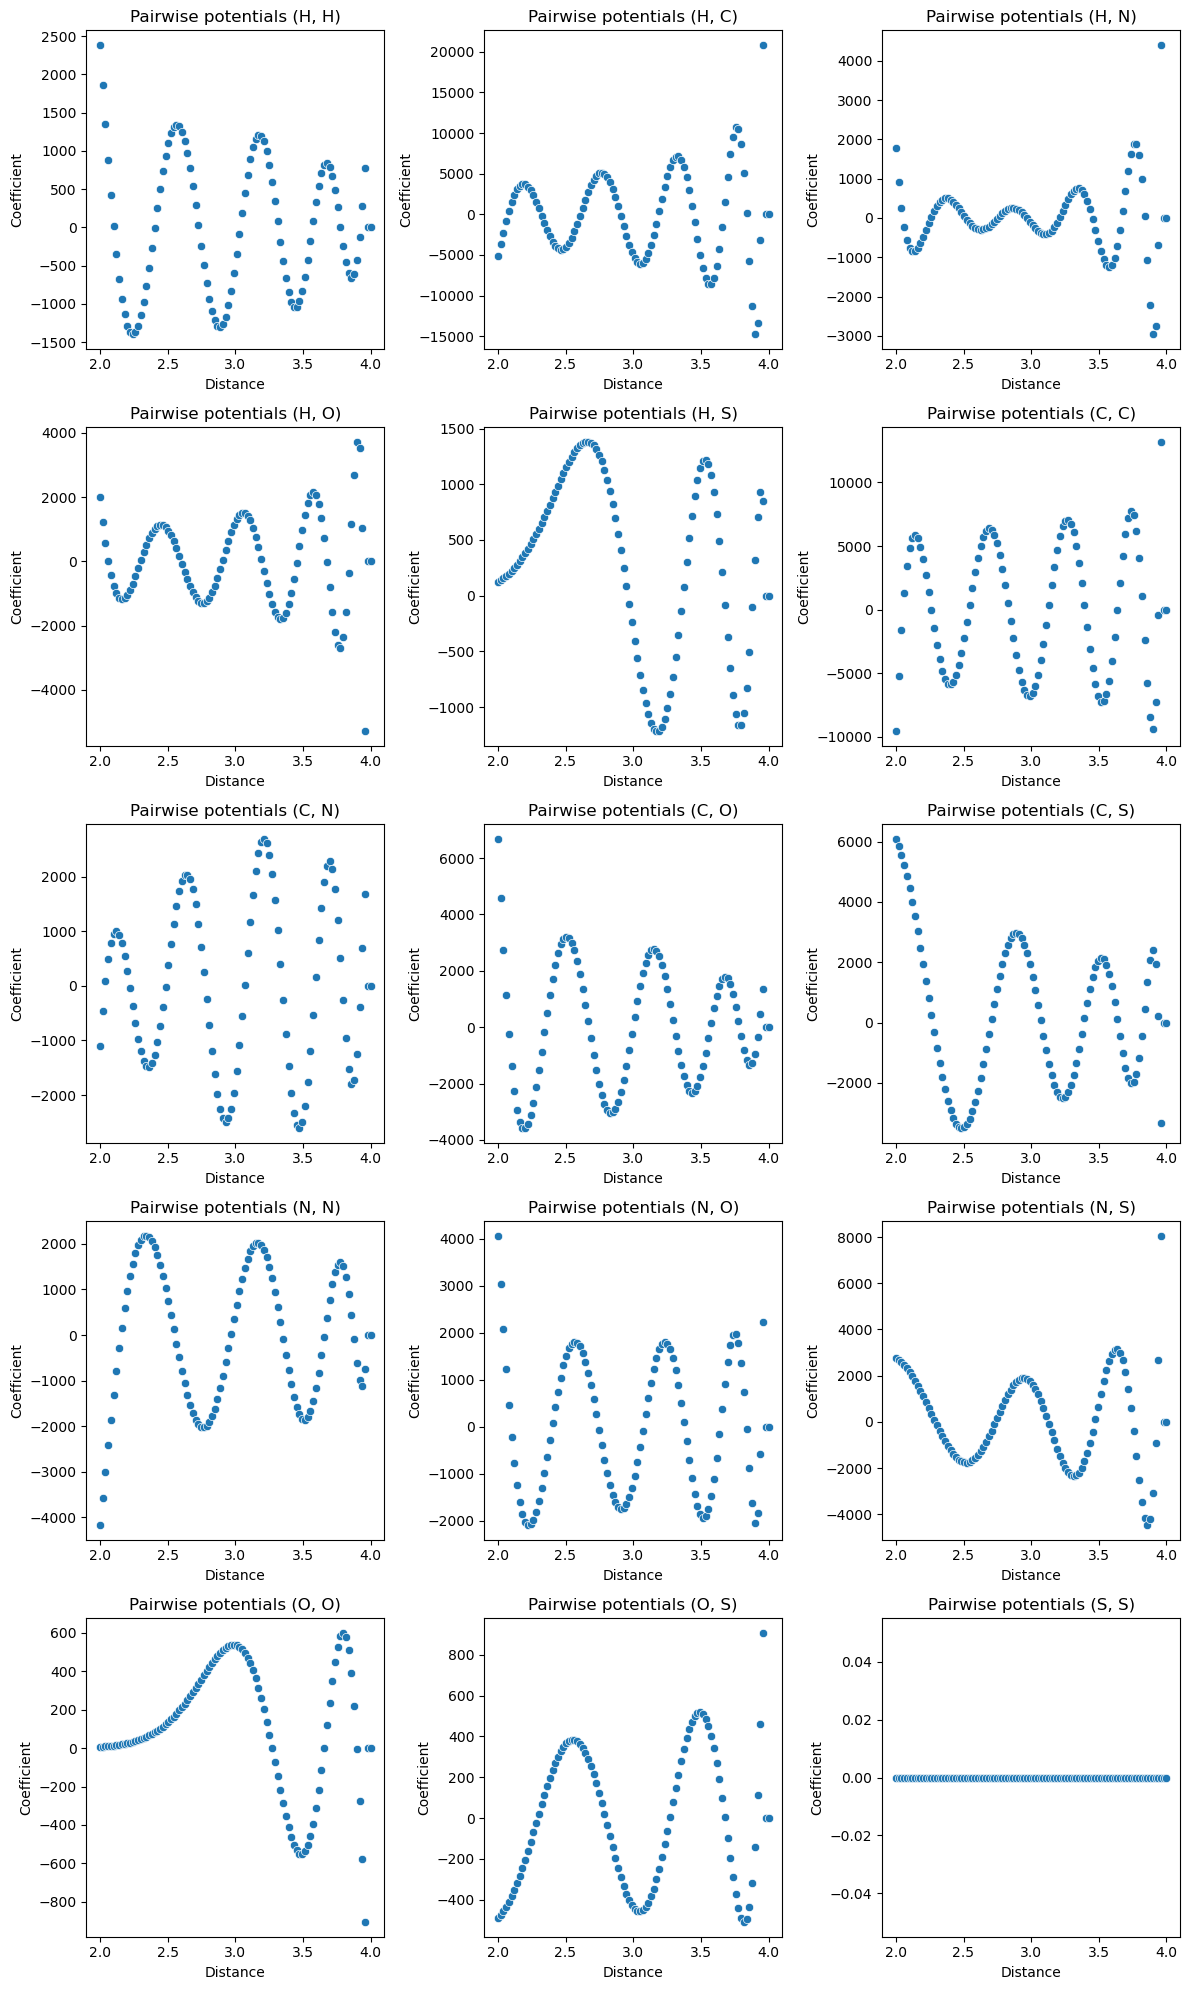

In [34]:
# Plot pairwise potentials (H-H pair)

fig, axes = plt.subplots(5, 3, figsize=(12, 20))
axes = axes.flatten()

pair_names = [*combinations_with_replacement(['H', 'C', 'N', 'O', 'S'], r=2)]

for i in range(15):
    g = sns.scatterplot(x=intervals, y=model.coef_.reshape(100, 15)[:, i], ax = axes[i])
    g.set_xlabel("Distance")
    g.set_ylabel("Coefficient")
    name = str(pair_names[i]).replace("'",'')
    g.set_title(f"Pairwise potentials {name}")
plt.tight_layout()
